# Problem Set 5 - Draft

In [2]:
using NLopt
using Optim
using ForwardDiff: gradient, hessian, jacobian
using Random
using LinearAlgebra
using TransformVariables

#### Exercise 1) (A) (i)

##### Write down the Lagrangian for the problem and write a function that calculates the gradient DL(x,λ).
$$\mathcal{L} = \sum_{i=1}^{n-1} [a(1 - x_i)^2 + b(x_{i+1} - x_i^2)^2] + \lambda \left(\sum_{i=1}^{n} x_i^2 - r\right)$$

In [3]:
#Set the seed 
Random.seed!(22)

#Define the Rosenbrock Function

function rosenbrock(x, a, b)
    n = length(x)
    sum = 0
    for i in 1:(n-1)
        sum += a * (1 - x[i])^2 + b * (x[i+1] - x[i]^2)^2
    end
    return sum
end

#Define its constraint, accounting for the number of dimensions n
function constraint(x, r)
    return sum(x .^ 2) - r
end;

In [4]:
#Write down the Lagrangian for the Rosenbrock function

function lagrange(D, a, b, r)
    X = D[1:end-1]  # Extracting the variables X from the input vector D
    λ = D[end]  # Extracting the Lagrange multiplier λ from the last element of D
    
    return rosenbrock(X, a, b) - λ * constraint(X, r)
end

# Calculate the gradient of the Lagrangian DL(x,λ). 

function L_autograd(D, a, b, r; quietly=true)
    short_lag = D -> lagrange(D, a, b, r)  # Abbreviate the Lagrangian in terms of D

    # Convert input D to a tensor for autograd
    if isa(D, Array)
        D_tensor = convert(Array{Float64}, D)  # Convert to Float64 array
    else
        D_tensor = convert(Array{Float64}, D.data)  # Convert to Float64 array (assuming D is a tensor)
    end
    
    # Calculate the gradient of the Lagrangian
    gradient = ForwardDiff.gradient(short_lag, D_tensor)
    
    if !quietly
        # Decompose the gradient of D into gradients of X and λ and print them
        println("-------dL/dX:-------")
        println(gradient[1:end-1])
        println("-------dL/dλ:-------")
        println(gradient[end])
    end
    
    return gradient
end;

In [5]:
# Calculate the gradient at each point using Finite Differences

function L_finite_diff(D, a, b, r; quietly=true)
    gradient = []
    short_lag = D -> lagrange(D, a, b, r)
    h = 1.0e-6  # Step size for finite differences
    
    for i in 1:length(D)
        D_plus_h = copy(D)
        D_minus_h = copy(D)
        
        D_plus_h[i] += h
        D_minus_h[i] -= h
        
        grad_approx = (short_lag(D_plus_h) - short_lag(D_minus_h)) / (2 * h)
        
        push!(gradient, grad_approx)  # Calculate the derivative of the lagrangian w.r.t each element of D, and append it to a list.
    end
    
    if !quietly
        println("-------dL/dX:-------")
        println(gradient[1:end-1])
        println("-------dL/dλ:-------")
        println(gradient[end])
    end
    
    return gradient
end;

In [6]:
#Test out the gradient function on several different points on the unit circle
using ForwardDiff

# Generate points and set the parameters
a=1
b=1
r=1
D0 = zeros(6)  

# Compute the gradient at each point
println("Autodifferentiation: " * string(L_autograd(D0, a, b, r)))
println("Finite diffs: " * string(L_finite_diff(D0, a, b, r)))


Autodifferentiation: [-2.0, -2.0, -2.0, -2.0, 0.0, 1.0]
Finite diffs: Any[-2.000000000279556, -2.000000000279556, -2.000000000279556, -2.000000000279556, 0.0, 1.000000000139778]


##### Comment: 

From an initial test with an array of 6 zeros, we see that the finite differences method produces a small error compared to the results given by the gradient function. 

In [7]:
# Generate a test set of points to test the gradient function

n = 5 # Number of dimensions
num_points = 100 # Number of points to sample uniformly from the unit circle

function generate_points(n::Int, num_points::Int)
    test_set = rand(n + 1, num_points)  # Generate random points in [0, 1]
    return test_set
end

test_set = collect(vec(generate_points(n, num_points)));

In [8]:
#Create a function to calculate RMSE

function RMSE(test_set, a, b, r)
    sum_distance = 0 
    y_act = L_autograd(test_set, a, b, r)
    y_approx = L_finite_diff(test_set, a, b, r) 
    v = y_act - y_approx
    sum_distance = dot(v, v)
    return sqrt(sum_distance / length(test_set))
end

#Test the RMSE function
println(RMSE(test_set, a, b, r))

1.4875555209254046e-8


In [9]:
#Testing the RMSE for different values of b

b = [1, 100, 1000, 10000000, 100000000]
for i in b
    error = RMSE(test_set, 1, i, 1)
    println("RMSE | b=$i: ", error)
end

RMSE | b=1: 1.4875555209254046e-8
RMSE | b=100: 5.064673638219819e-7
RMSE | b=1000: 4.209364550554393e-6
RMSE | b=10000000: 0.0649815614680916
RMSE | b=100000000: 0.5810571688938057


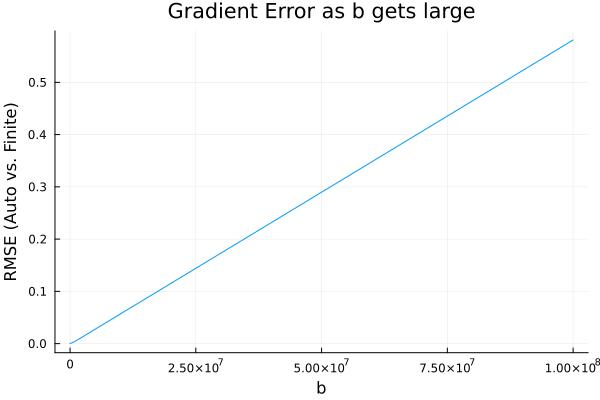

In [10]:
#Testing very large values of b where finite differences stop working well

using Plots

# Define the values of b and corresponding errors
b = [1, 100, 1000, 1000000, 100000000]
error = [RMSE(test_set, 1, i, 1) for i in b]

# Create a plot
plot(b, 
error,
xlabel="b",
ylabel="RMSE (Auto vs. Finite)",
title="Gradient Error as b gets large", legend=false)

##### Comment: 

As b increases, the RMSE grows without bound. In the Rosenbrock function, the parameter b controls the influence of the quadratic term on the function's curvature. Thus, when b is large, the curves of the corresponding rosenbrock function become much greater. This leads to an increased difficulty in approximating using finite differences - small perturbations from an initial point are no longer sufficient to account for the variance in slope. 

In comparison, the autodifferentiated gradient will remain relatively precise, as it is deriving the computations in the program to calculate exact derivatives. 

In addition, there are also numerical instability problems when using a finite-differences method, likely as a result of rounding errors. This might add some additional inaccuracy when trying to estimate for large parameter values. 


#### (A) (ii)

#### Implement Newton’s method yourself, and then use it to solve the constrained Rosenbrock problem with sequential quadratic programming

In [11]:
function newton(f, x0; tol = 1e-5, itermax = 100, trace=false)
    x    = copy(x0)
    err  = Inf
    iter = 0
    X_history = []
    while ! (err < tol) && iter < itermax

        # Calculate the gradient and the Hessian
        fx  = f(x)
        Df   = gradient(f, x)
        D²f  = hessian(f, x)

        # search direction
        sk = -D²f\Df

        # update x
        x′ = x + sk
        
        # Check for convergence
        err = norm(x′ - x)

        # copy x′ to be old x and start again
        x .= x′
        iter += 1

        push!(X_history, x′)  # Append the new x to the history
        trace && @info "Trace Information" iter x fx = f(x)
    end

    return (;fx = f(x), x, iter, X_history)
end;

Set the parameters and initial values for the Newton method, then plot the progress of the algorithm (the values of xk at each step, the constraint set, and the contours of f)

┌ Info: Trace Information
│   iter = 1
│   x = [1.679787234042553, 1.2202127659574469, 0.09095744680851045]
│   fx = 2.8166578138266085
└ @ Main /Users/ciandelahunty/Desktop/Julia/PS5_almost_final.ipynb:27
┌ Info: Trace Information
│   iter = 2
│   x = [1.2008420305413894, 0.9327414789261879, -0.2079505707626216]
│   fx = 0.36459019737651965
└ @ Main /Users/ciandelahunty/Desktop/Julia/PS5_almost_final.ipynb:27
┌ Info: Trace Information
│   iter = 3
│   x = [1.0314141826684697, 0.983604400249792, -0.043879303890555305]
│   fx = 0.00879373357217125
└ @ Main /Users/ciandelahunty/Desktop/Julia/PS5_almost_final.ipynb:27
┌ Info: Trace Information
│   iter = 4
│   x = [1.00112115723421, 0.999462645561282, -0.0011868691775176882]
│   fx = 1.0378172091464371e-5
└ @ Main /Users/ciandelahunty/Desktop/Julia/PS5_almost_final.ipynb:27
┌ Info: Trace Information
│   iter = 5
│   x = [1.000001426016112, 0.9999993449047497, -1.6172086130181174e-6]
│   fx = 1.6826963034928108e-11
└ @ Main /Users/ciandela

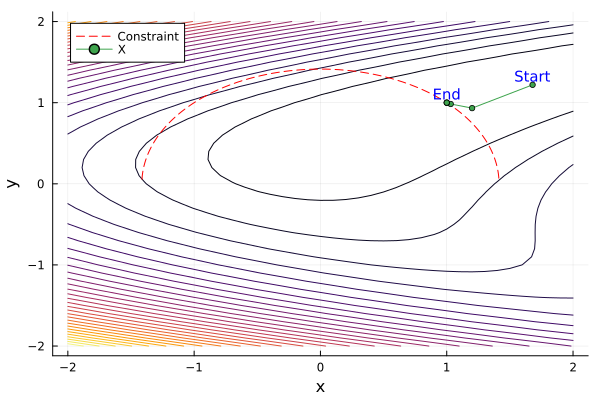

In [12]:
# Set the parameters and initial values for the Newton method

n = 2
a = 1
b = 1
r = 2
x0 = [0.4, 0.4] # Initial guess of [0,0] returns a SingularException error!
λ0 = 0
D0 = [x0..., λ0]

# Define the function to be minimized
f(D) = lagrange(D, a, b, r)

# Run the Newton method
result = newton(f, D0, trace=true)

# Access the X_history from the result
X_history = result.X_history
start_point = X_history[1]
end_point = X_history[end]

# Generate a grid of x and y values
x_range = -2:0.1:2
y_range = -2:0.1:2

# Evaluate the Rosenbrock function at each point on the grid
z_values = [rosenbrock([x, y], a, b) for x in x_range, y in y_range]

# Create the contour plot
contour_plot = contour(x_range, y_range, z_values, levels=30, xlabel="x", ylabel="y", legend=false)

# Define the constraint plot
constraint_plot = plot!(x -> sqrt(r - x^2), -sqrt(r), sqrt(r), color=:red, linestyle=:dash, label="Constraint", legend=true)

# Create a scatter plot of the x values in X history
x_history_plot = plot!([x[1] for x in X_history], [x[2] for x in X_history], marker=:circle, markersize=3, label="X")
annotate!([(start_point[1], start_point[2], text("Start", :bottom, 10, :blue)),
            (end_point[1], end_point[2], text("End", :bottom, 10, :blue))])

##### Comment: 

The Newton method produces a Singular Exception error with an initial guess of $x_0 = [0, 0]$. This is due to the Hessian matrix being singular (therefore not invertible). This means that the optimization algorithm cannot determine a proper direction for convergence, which halts the Newton method's progress. Our proposed solution is simply to begin with a different initial guess. You can also begin with an initial guess very close to $[0, 0]$ in order to avoid this error, while capturing similar information. 

We observe at a starting point of $x_0 = [0.4, 0.4]$ the solution converges towards $[1,1]$ as expected. From the output, you can see that this takes 6 iterations, where x moves from an initial value of $[1.679, 1.220]$.


#### (A) (iii)

#### How sensitive are the results to the initial guess?

In [13]:
initial_guess = [0.1, 0.0, 0.0]

# Generate values for the first element of the initial guess vector
step_size = 0.1
range_values = LinRange(0, 3, Int(10 / step_size) + 1)

for i in range_values
    initial_guess[1] = 0.1 + i
    result = newton(f, initial_guess, tol=1e-8, itermax=100, trace=false)
    if result.x[1] != 1
        println("The Newton method was off when initial guesses were:")
        println(initial_guess)
        println("Giving the estimated vector of:")
        println(result.x)
        break
    end
end

The Newton method was off when initial guesses were:


[0.19, 0.0, 0.0]
Giving the estimated vector of:
[0.3454930785858994, -1.3713622908076617, 1.0870415266271194]


##### Comment:

The Newton method converges to the optimal solution quickly. However, it's quite sensitive to initial guesses, $x_0$, as seen with the substantial deviation from the expected solution when starting from $[0.19, 0.0, 0.0]$. Additionally, the displayed root mean square error (RMSE) values highlight varying levels of accuracy across different parameter settings. Lower RMSE values indicate superior performance, especially with smaller values of 'b'.

#### (A) (iv)

#### Try out your function for a variety of parameters and report the results.

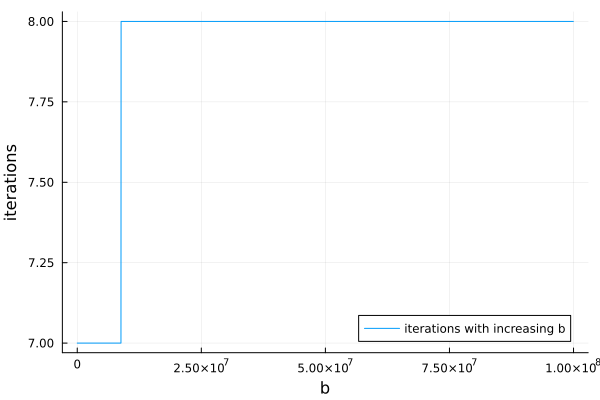

In [14]:
a_value = 1.0
b_value = 1.0
r_value = 2.0

initial_guess = [1.0, 0.0, 0.0]
b_list = []
iter_list = []
a_list =[]

f(D) = lagrange(D, a, b_value, r)

## changing b
for i in 3:50:100000
    b_value += i
    result = newton(f, initial_guess, tol=1e-6, itermax=100, trace=false)
    push!(iter_list,result.iter)
    push!(b_list, b_value)
    if result.x[1] != 1
        println("stopped estimating correctly for b equal to: ")
        println(b_value)
        println("It took", result.iter, "iterations")
        break
    end
end

plot()
plot!(b_list, iter_list, label = "iterations with increasing b", ylabel = "iterations", xlabel = "b")

##### Comment: 

The Newton method works even for very high values of b - we are still able to find the true minimum. Eventually the amount of iterations increases, but only by 1 (from 7 to 8).

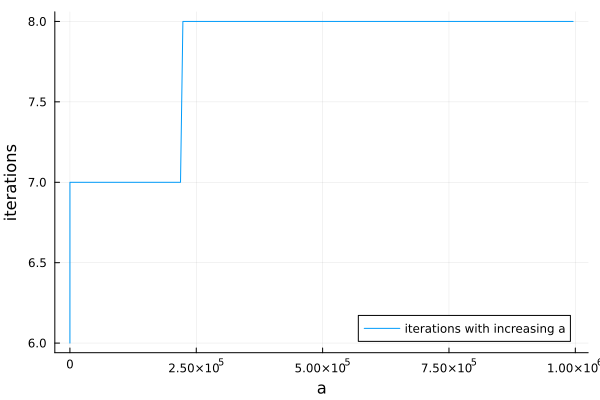

In [15]:
iter_list = []
a_list = []
b_value = 1.0
a_value = 1.0

f(D) = lagrange(D, a_value, b, r)

# Changing a_value
for i in 3:50:10000
    a_value += i
    result = newton(f, initial_guess, tol=1e-6, itermax=100, trace=false)
    push!(iter_list, result.iter)
    push!(a_list, a_value)
    if result.x[1] != 1
        println("stopped estimating correctly for a equal to: ")
        println(a_value)
        println("It took ", result.iter, " iterations")
        break
    end
end

plot(a_list, iter_list, label="iterations with increasing a", ylabel="iterations", xlabel="a")

##### Comment: 

As we increase the value of a, the function takes a marginally greater amount of iterations, but only makes small steps from values of 6, 7 and 8.  Estimates remain correct at all values of a, no matter the number of iterations.

Estimates change for each value of r in an unstable way
Iterations increase with increases in r, although not in a stable way


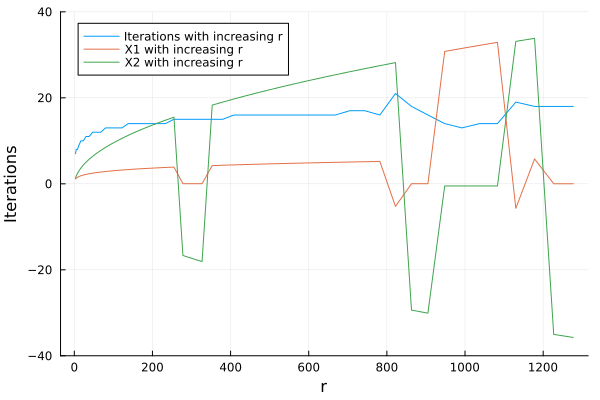

In [16]:
a_value = 1.0
b_value = 1.0
r_value = 2.0
r_list = []
iter_list = []
x1_list = []
x2_list = []

f(D) = lagrange(D, a, b, r_value)

for i in 1:1:50
    r_value += i
    result = newton(f, initial_guess, tol=1e-6, itermax=100, trace=false)
    push!(iter_list, result.iter)
    push!(r_list, r_value)
    push!(x1_list, result.x[1])
    push!(x2_list, result.x[2])
end

println("Estimates change for each value of r in an unstable way")
println("Iterations increase with increases in r, although not in a stable way")

plot(r_list, iter_list, label="Iterations with increasing r", ylabel="Iterations", xlabel="r", ylim=(-40, 40))
plot!(r_list, x1_list, label="X1 with increasing r")
plot!(r_list, x2_list, label="X2 with increasing r")

##### Comment: 

Since dramatically increasing both parameters a and b does not change the final estimates given by the Newton method, we can infer that while function is complicated, we still achieve convergence as long as the initial guess is close. Increasing values a and b only marginally increases the amount of iterations needed.

Increasing r requires more iterations and changes the estimates, though both follow an unstable path. This is sensible as changing the constraint adds extra complications to finding an optimum. Overall, r has a much greater effect on the number of iterations required. 

#### (B) (i)

#### Penalty Method

In [17]:
using Optim
using LinearAlgebra

# Define the Rosenbrock objective function
function f(X, N, a, b)
    Y = 0
    N = length(X)
    for i in 1:(N-1)
        Y += a * (1 - X[i])^2 + b * (X[i+1] - X[i]^2)^2
    end
    return Y
end

global function_evaluations = 0

# Define the penalty function
function penalty(x, params)
    global function_evaluations
    function_evaluations += 1
    a, b, r, N, pk = params 
    return f(x, N, a, b) + pk * norm(constraint(x, r))^2
end

# Reset the function evaluation counter
function reset_function_evaluations()
    global function_evaluations = 0
end

# Definition of Parameters 
a = 10
b = 10
r = 10
N = 10
pk = 10^12
x0 = [0.0] * N
params = [a, b, r, N, pk]  

# Define the objective function for optimization
objective(x) = penalty(x, params)

# Minimizing using L-BFGS-B method (using LBFGS() in Optim.jl)
result = Optim.optimize(objective, x0, LBFGS())

println("Number of function evaluations: ", function_evaluations)
println("Optimal solution: ", Optim.minimizer(result))
println("Optimal value: ", Optim.minimum(result))

Number of function evaluations: 3
Optimal solution: [0.0]
Optimal value: 1.0e14


##### Comment: 

The LBFGS takes 3 function evalutations and one iteration to converge to the final value of $[0.0]$. However, given such a large penalty, the function is likely badly conditioned. A badly conditioned function is prone to numerical instability, which can create inaccuracy in the final result. 

A possible improvement could be a smaller initial penalty, which we gradually increase across iterations, allowing the method to violate the constraint when it makes sense. This will also hopefully allieviate any numerical instability. 

#### (B) (ii)

#### Starting with P0 = 1, solve a sequence of problems with Pk+1 = 10 × Pk at each iteration

In [43]:
using Optim

# Definition of Parameters 
a = 10
b = 10
r = 10
N = 10
x0 = fill(0.0, N)

#Start with pk =1, and define a loop that sets Pk+1 = 10 × Pk, minimizing using the LBFGS method
for i in 1:13
    pk = 10^(i-1)
    params = [a, b, r, N, pk]  
    f(x) = penalty(x, params)
    result = Optim.optimize(f, x0, LBFGS())
    println("For pk = ", pk, " the result is: ", Optim.minimizer(result)[1], ", ", Optim.minimizer(result)[2] , ", .... , ", Optim.minimizer(result)[10])
end

For pk = 1 the result is: 0.9999999999842063, 0.999999999980759, .... , 1.0000000000380946
For pk = 10 the result is: 0.9999999999833218, 0.9999999999803142, .... , 1.0000000000610498
For pk = 100 the result is: 0.9999999999318476, 0.9999999999492283, .... , 1.000000000278286
For pk = 1000 the result is: 0.9999999999939769, 0.9999999999891596, .... , 1.0000000000517775
For pk = 10000 the result is: 0.9999999999751432, 0.9999999999770937, .... , 1.000000000027838
For pk = 100000 the result is: 0.9999999999559888, 0.9999999999361432, .... , 1.00000000018223


For pk = 1000000 the result is: 1.0000000000751978, 1.0000000000078464, .... , 1.0000000001738862
For pk = 10000000 the result is: 1.0000000001283162, 0.9999999992356947, .... , 1.0000000037828738
For pk = 100000000 the result is: 1.02831121033636, 1.0401039015113434, .... , 0.9331659573730193
For pk = 1000000000 the result is: 1.0697341949445816, 1.0847846392296627, .... , 0.5324129890067766
For pk = 10000000000 the result is: 1.078239781915968, 1.0903619385103092, .... , 0.22480694433329101
For pk = 100000000000 the result is: 0.0, 0.0, .... , 0.0
For pk = 1000000000000 the result is: 0.0, 0.0, .... , 0.0


##### Comment: 

The above output shows the convergence for different iterations of pk, going from 1 to 10^12. As the penalty becomes very large, the minimization function begins to report an array of zeroes instead of converging to the known minimum of 1. 

In [44]:
x0 = fill(0.5, N)

#Start with pk =1, and define a loop that sets Pk+1 = 10 × Pk, minimizing using the LBFGS method
for i in 1:13
    pk = 10^(i-1)
    params = [a, b, r, N, pk]  
    f(x) = penalty(x, params)
    result = Optim.optimize(f, x0, LBFGS())
    println("For pk = ", pk, " the result is: ", Optim.minimizer(result)[1], ", ", Optim.minimizer(result)[2] , ", .... , ", Optim.minimizer(result)[10])
end

For pk = 1 the result is: 0.9999999999849445, 0.9999999999818884, .... , 1.000000000037418
For pk = 10 the result is: 0.999999999997021, 1.0000000000017861, .... , 1.000000000173615
For pk = 100 the result is: 0.9999999999872408, 0.999999999984804, .... , 1.0000000000705915
For pk = 1000 the result is: 0.999999999991883, 0.9999999999756112, .... , 1.0000000000790508


For pk = 10000 the result is: 0.9999999999878385, 0.9999999999862216, .... , 1.0000000000765796
For pk = 100000 the result is: 1.0000000004478231, 1.0000000002133969, .... , 1.000000000280189
For pk = 1000000 the result is: 0.9999999997320704, 0.9999999997623116, .... , 1.0000000000938687
For pk = 10000000 the result is: 1.00000002943506, 1.0000000045693005, .... , 0.9999999340363696
For pk = 100000000 the result is: 1.000000001911219, 1.0000000003124283, .... , 0.9999999956225444
For pk = 1000000000 the result is: 1.000000000212452, 1.0000000000381886, .... , 0.9999999994922781
For pk = 10000000000 the result is: 0.9999999999927407, 1.0000000000188738, .... , 0.9999999999224847
For pk = 100000000000 the result is: 1.0000000000039515, 1.0000000000038498, .... , 0.9999999999954106
For pk = 1000000000000 the result is: 0.999999999997817, 0.9999999999978169, .... , 0.9999999999932132


If we change the initial guess to be an array of 0.5 * N, the penalty method continues to converge to the true minimum even at very large values of pk, greatly improving performance. 

In [45]:
x0 = fill(1.0, N)

#Start with pk =1, and define a loop that sets Pk+1 = 10 × Pk, minimizing using the LBFGS method
for i in 1:13
    pk = 10^(i-1)
    params = [a, b, r, N, pk]  
    f(x) = penalty(x, params)
    result = Optim.optimize(f, x0, LBFGS())
    println("For pk = ", pk, " the result is: ", Optim.minimizer(result)[1], ", ", Optim.minimizer(result)[2] , ", .... , ", Optim.minimizer(result)[10])
end

For pk = 1 the result is: 1.0, 1.0, .... , 1.0
For pk = 

10 the result is: 1.0, 1.0, .... , 1.0
For pk = 100 the result is: 1.0, 1.0, .... , 1.0
For pk = 1000 the result is: 1.0, 1.0, .... , 1.0
For pk = 10000 the result is: 1.0, 1.0, .... , 1.0
For pk = 100000 the result is: 1.0, 1.0, .... , 1.0
For pk = 1000000 the result is: 1.0, 1.0, .... , 1.0
For pk = 10000000 the result is: 1.0, 1.0, .... , 1.0
For pk = 100000000 the result is: 1.0, 1.0, .... , 1.0
For pk = 1000000000 the result is: 1.0, 1.0, .... , 1.0
For pk = 10000000000 the result is: 1.0, 1.0, .... , 1.0
For pk = 

100000000000 the result is: 1.0, 1.0, .... , 1.0
For pk = 1000000000000 the result is: 1.0, 1.0, .... , 1.0


##### Comment:

*How do your results compare? Do you converge to the true minimum? If not, try again with a better initial guess (remember, in this case you know where the true minimum is). Does it improve?*

By iterating our values of $P_k$ from $[1,10^{12}]$, we find that smaller values of $P_k$ are often efficient at finding the true minimum of the rosenbrock. Compared to a flat value of $P_k$, the process of iterating is much more effective. 

When varying our initial guess, we find that the performance of the penalty method is very dependent on how we choose the starting point. Given an initial guess of $0.0$, larger penalties lead to no iterations at all. When we select a guess of $0.5$, the penalty method is able to converge to our true minimum at any value of pk. When our initial guess is at the true minimum of $1.0$, the function does not deviate from the starting point, and thus the value of pk has no impact. 

#### (B) (iii)

#### Repeat with b = 1000

In [50]:
# Definition of Parameters 
a = 10
b = 1000 # Define b = 1000
r = 10
N = 10
x0 = fill(9.0, N)
params = [a, b, r, N, pk]  

# Minimizing using L-BFGS-B method (using LBFGS() in Optim.jl)
result = Optim.optimize(objective, x0, LBFGS())

println("Optimal solution: ", Optim.minimizer(result))
println("Optimal value: ", Optim.minimum(result))
println(" ")

#Start with pk =1, and define a loop that sets Pk+1 = 10 × Pk, minimizing using the LBFGS method
for i in 1:13
    pk = 10^(i-1)
    params = [a, b, r, N, pk]  
    f(x) = penalty(x, params)
    result = Optim.optimize(f, x0, LBFGS())
    println("For pk = ", pk, " the result is: ", Optim.minimizer(result)[1], ", ", Optim.minimizer(result)[2] , ", .... , ", Optim.minimizer(result)[10])
end

Optimal solution: [1.0000000002770322, 1.0000000001178124, 1.0000000001178124, 1.0000000001178124, 1.0000000001178124, 1.0000000001178124, 1.0000000001178124, 1.0000000001178124, 1.0000000001178122, 0.9999999987621347]
Optimal value: 1.3443819951472842e-9
 
For pk = 1 the result is: 0.999999999964692, 0.9999999999507123, .... , 0.9999999963316437
For pk = 10 the result is: 0.999999999974838, 0.999999999968128, .... , 0.999999999675622
For pk = 100 the result is: -0.9933189654218564, 0.9967012239393527, .... , 1.0065343537637976
For pk = 1000 the result is: 0.9999999999762045, 0.9999999999714971, .... , 1.0000000001116731
For pk = 10000 the result is: -0.9933190769787855, 0.9967014151896296, .... , 1.0065712618887037
For pk = 100000 the result is: -0.9933190780331383, 0.9967014169786192, .... , 1.006571597901843
For pk = 1000000 the result is: -0.9933190785173641, 0.9967014176224634, .... , 1.0065716296555314
For pk = 

10000000 the result is: -0.9933190823531962, 0.9967014223375028, .... , 1.0065716143235128
For pk = 100000000 the result is: -1.190454899302254, 1.1812669447568802, .... , 0.05279611031508449
For pk = 1000000000 the result is: -1.189121132265049, 1.056136095836142, .... , -2.644153336536408
For pk = 10000000000 the result is: 0.999999959298508, 0.9999999774043209, .... , 1.0000002086960595
For pk = 100000000000 the result is: 0.999999999447284, 1.0000000012962058, .... , 0.9999999907711652
For pk = 1000000000000 the result is: 1.0000000002770322, 1.0000000001178124, .... , 0.9999999987621347


In [52]:
# Definition of Parameters 
a = 10
b = 1000 # Define b = 1000
r = 10
N = 10
x0 = fill(0.1, N)
params = [a, b, r, N, pk]  

# Minimizing using L-BFGS-B method (using LBFGS() in Optim.jl)
result = Optim.optimize(objective, x0, LBFGS())

println("Optimal solution: ", Optim.minimizer(result))
println("Optimal value: ", Optim.minimum(result))
println(" ")

#Start with pk =1, and define a loop that sets Pk+1 = 10 × Pk, minimizing using the LBFGS method
for i in 1:13
    pk = 10^(i-1)
    params = [a, b, r, N, pk]  
    f(x) = penalty(x, params)
    result = Optim.optimize(f, x0, LBFGS())
    println("For pk = ", pk, " the result is: ", Optim.minimizer(result)[1], ", ", Optim.minimizer(result)[2] , ", .... , ", Optim.minimizer(result)[10])
end

Optimal solution: [1.0000000000077671, 0.9999999999982473, 0.9999999999982474, 0.9999999999982473, 0.9999999999982474, 0.9999999999982474, 0.9999999999982474, 0.9999999999982474, 0.9999999999982411, 0.9999999999879268]
Optimal value: 1.3442492751497273e-9
 
For pk = 1 the result is: 0.999999999964728, 0.9999999999507074, .... , 0.9999999963314781
For pk = 

10 the result is: 0.9999999999747254, 0.9999999999678215, .... , 0.9999999996762758
For pk = 100 the result is: 0.9999999999758513, 0.999999999970384, .... , 1.0000000000793332
For pk = 1000 the result is: 0.9999999999760726, 0.9999999999703284, .... , 1.0000000001200091
For pk = 10000 the result is: 0.999999999976533, 0.99999999997058, .... , 1.000000000122888
For pk = 100000 the result is: 0.9999999999805884, 0.9999999999750276, .... , 1.0000000001152614
For pk = 1000000 the result is: 0.9999999999765531, 0.9999999999709193, .... , 1.0000000001222218
For pk = 10000000 the result is: 1.0000000000139395, 0.9999999999806513, .... , 1.0000000001343936
For pk = 100000000 the result is: 1.0000000229844537, 1.000000032695046, .... , 0.9999999008202716
For pk = 1000000000 the result is: 1.000000007461223, 1.000000012780223, .... , 0.9999999876300723
For pk = 10000000000 the result is: 1.0000000037498387, 0.9999999996912228, .... , 0.9999999987652678
For pk = 

100000000000 the result is: 1.0000000006545517, 0.9999999999239796, .... , 0.9999999999323159
For pk = 1000000000000 the result is: 1.0000000000077671, 0.9999999999982473, .... , 0.9999999999879268


##### Comment: 

When $b = 1000$, the impact of the initial guess seems to be much smaller. As seen above, even when varying the initial guess from $0.1$ to $9.0$, the function performs similarly at all values of $P_k$. Its possible that the increased curvature of the Rosenbrock function dominates over the differences in the initial conditions, as well as the poor conditioning caused by variance in the penalty value. 


#### (B) (iv)

#### Repeat with r = 1

In [54]:
# Definition of Parameters 
a = 10
b = 10 
r = 1 # Define r = 1
N = 10
x0 = fill(0.5, N)
pk = 10^12
params = [a, b, r, N, pk]  

# Minimizing using L-BFGS-B method (using LBFGS() in Optim.jl)
result = Optim.optimize(objective, x0, LBFGS())

println("Optimal solution: ", Optim.minimizer(result))
println("Optimal value: ", Optim.minimum(result))
println(" ")

#Start with pk =1, and define a loop that sets Pk+1 = 10 × Pk, minimizing using the LBFGS method
for i in 1:13
    pk = 10^(i-1)
    params = [a, b, r, N, pk]  
    f(x) = penalty(x, params)
    result = Optim.optimize(f, x0, LBFGS())
    println("For pk = ", pk, " the result is: ", Optim.minimizer(result)[1], ", ", Optim.minimizer(result)[2] , ", .... , ", Optim.minimizer(result)[10])
end

Optimal solution: [0.34670725551342246, 0.32145003638915126, 0.3217079198122181, 0.3217100431556616, 0.321706310637879, 0.32170002253783875, 0.3217134670598429, 0.3217001708413932, 0.32269772549493675, 0.22662832930045948]
Optimal value: 44.95801642817368
 


For pk = 1 the result is: 0.7567124670113009, 0.7084000588578704, .... , 0.15269370488223621
For pk = 10 the result is: 0.5196451321283566, 0.4490265845076017, .... , 0.050716705382377596
For pk = 100 the result is: 0.42320348636024785, 0.3584430867351873, .... , 0.030896789244931472
For pk = 1000 the result is: 0.4073560548251735, 0.34437440968479716, .... , 0.028231997950058756
For pk = 10000 the result is: 0.4056360972284765, 0.34286016987104095, .... , 0.02795152805340204
For pk = 100000 the result is: 0.40546256120524954, 0.3427075250021122, .... , 0.02792332334354351
For pk = 1000000 the result is: 0.4054451919801342, 0.34269224812752114, .... , 0.027920501263091736
For pk = 10000000 the result is: 0.4054434624325757, 0.3426906919377156, .... , 0.027920221516863054
For pk = 100000000 the result is: 0.40544327553557097, 0.3426905768293336, .... , 0.027920188633891136
For pk = 

1000000000 the result is: 0.4054430708652204, 0.3426905614170487, .... , 0.02792012093404818
For pk = 10000000000 the result is: -0.33200367195183866, -0.158790758010736, .... , -0.8269330344044344
For pk = 100000000000 the result is: 0.37429996231874324, 0.3266159149139448, .... , 0.13735334227152693
For pk = 1000000000000 the result is: 0.34670725551342246, 0.32145003638915126, .... , 0.22662832930045948


##### Comment: 

Changing the value of r from 10 to 1 causes the constraint to become much smaller. The penalty method struggles to converge to the true minimum under these conditions. The first reason is that a stronger constraint means the penalty term is much larger relative to any chosen value of $P_k$. This could create more numerical instability. Another reason is that the constraint has limited the set of possible points too much, and the method can no longer iterate over a path of values that it previously was able to. 

In addition, we note that $r \neq N$ for $r=1$, so as the loop continues and $P_k$ grows larger it forces the optimisation method away from $x_i =1$

In [57]:
#Using the constraint function, calculate how much the constraint is violated by for given values of r and N
function constraint_violation(x, r)
    return sum(x .^ 2) - r
end

# Define the parameters
r = 1
N = 10
x = fill(0.0, N)

# Calculate the constraint violation
println("Constraint violation: ", constraint_violation(x, r))


Constraint violation: -1.0


#### (C) (i)

#### Do you find the true minimum? How large does Pk need to be when λ converges?

In [59]:
using Optim
using LinearAlgebra
function f(X, N, a, b)
    Y = 0
    for i in 1:N-1
        Y += (a * (1 - X[i])^2 + b * (X[i+1] - X[i]^2)^2)
    end
    return Y
end

function g(X, N, r)
    Y = 0
    for i in 1:N
        Y += X[i]^2
    end
    return Y - r
end

function augmented(X, params)
    alpha, b, r, N, pk, λ = params 
    g_value = g(X, N, r)
    return f(X, N, alpha, b) + ((pk/2) * (norm(g_value)^2)) + (λ * g_value)
end

# Defining parameters
alpha = 10
b = 10
r = 10
N = 10
pk = 1
x0 = fill(0.0, N)
λ_k = 0 # Starting guess for lambda
params = [alpha, b, r, N, pk, λ_k]
tol = 1e-2 # Error tolerance in the iterated lambda

# Declare x_k before the loop
x_k = x0

# While loop to minimize the Rosenbrock subject to the constraints

while true
    # Solve the inner problem
    res = Optim.optimize(x -> augmented(x, params), x0, LBFGS())
    x_k = Optim.minimizer(res)
    g_x = g(x_k, N, r)
    λ_kp1 = λ_k + (g_x) * pk
    if norm(λ_kp1 - λ_k)^2 < tol
        break
    end
    pk *= 10
    x0 = x_k
    λ_k = λ_kp1
    println(pk)
end

println(x_k)
println(pk)

[0.9999999999822031, 0.999999999978078, 0.9999999999789737, 0.9999999999800621, 0.999999999977687, 0.9999999999790086, 0.9999999999811107, 0.9999999999845338, 0.9999999999907228, 1.0000000000093388]
1


*Report
your results.
Do you find the true minimum? How large does Pk need to be when λ converges?*

When the constraint isn't binding i.e. $r = N$ we instantly converge to the solution, as shown with a $P_{k} = P_{0} = 1$. So in this case, we do not need to increase the penalty term to converge to the correct solution of $1$. However, it does appear that this convergence around $1$ is extremely fragile. In fact, $P_{k} \rightarrow \infty$ if $r \notin [9.62, 10.42]$
or the initial guess, $\lambda_{0} > 0.14$. This holds true even if the step-size increases: the algorithm still diverges, just more slowly.

#### (C) (ii)
#### Compare the performance of the Augmented Lagrangian to the standard Penalty Method

In [60]:
using Optim

# Define the objective function
function f(X, N, a, b)
    Y = 0
    for i in 1:N-1
        Y += (a * (1 - X[i])^2 + b * (X[i+1] - X[i]^2)^2)
    end
    return Y
end

# Define the constraint function
function g(X, N, r)
    Y = 0
    for i in 1:N
        Y += X[i]^2
    end
    return Y - r
end

# Define the penalty function
function penalty(X, params)
    a, b, r, N, pk = params
    return f(X, N, a, b) + (pk * (norm(g(X, N, r))^2))
end

# Define the augmented Lagrangian function
function augmented(X, params)
    a, b, r, N, pk, λ = params 
    g_value = g(X, N, r)
    return f(X, N, a, b) + ((pk/2) * (norm(g_value)^2)) + (λ * g_value)
end

# Set the parameters
a = 10
b = 10
r = 10
N = 10
pk = 1
λ = 0
tol = 1e-8

# Define the true minimum
true_minimum = fill(1.0, N)

# Define a range of initial guesses
initial_guesses = [fill(0.0, N), fill(0.5, N), fill(0.9, N), fill(0.99, N), fill(0.999, N)]

# Initialize arrays to store results
penalty_iterations = []
penalty_evaluations = []
augmented_iterations = []
augmented_evaluations = []

# Set the parameters for the Penalty method
penalty_params = [a, b, r, N, pk]
# Set the parameters for the Augmented Lagrangian method
augmented_params = [a, b, r, N, pk, λ]

# Iterate over the initial guesses
for x0 in initial_guesses
    # Run the Penalty method
    penalty_result = Optim.optimize(x -> penalty(x, penalty_params), x0, LBFGS())
    penalty_iterations = [penalty_iterations; Optim.iterations(penalty_result)]
    penalty_evaluations = [penalty_evaluations; Optim.f_calls(penalty_result)]
    
    # Run the Augmented Lagrangian method
    augmented_result = Optim.optimize(x -> augmented(x, augmented_params), x0, LBFGS())
    augmented_iterations = [augmented_iterations; Optim.iterations(augmented_result)]
    augmented_evaluations = [augmented_evaluations; Optim.f_calls(augmented_result)]
end

# Print the results
println("Performance Comparison:")
println("Initial Guess\tPenalty Iterations\tPenalty Evaluations\tAugmented Iterations\tAugmented Evaluations")
for i in 1:length(initial_guesses)
    println("$i\t\t$(penalty_iterations[i])\t\t\t$(penalty_evaluations[i])\t\t\t$(augmented_iterations[i])\t\t\t$(augmented_evaluations[i])")
end


# Initialize arrays to store timing results
penalty_times = []
augmented_times = []

# Iterate over the initial guesses
for x0 in initial_guesses
    # Measure the time taken by the Penalty method
    penalty_time = @elapsed begin
        penalty_result = Optim.optimize(x -> penalty(x, penalty_params), x0, LBFGS())
    end
    push!(penalty_times, penalty_time)
    
    # Measure the time taken by the Augmented Lagrangian method
    augmented_time = @elapsed begin
        augmented_result = Optim.optimize(x -> augmented(x, augmented_params), x0, LBFGS())
    end
    push!(augmented_times, augmented_time)
end

# Print the timing results
println("Performance Comparison (Time):")
println("Initial Guess\tPenalty Time (s)\tAugmented Time (s)")
for i in 1:length(initial_guesses)
    println("$i\t\t$(penalty_times[i])\t\t$(augmented_times[i])")
end


Performance Comparison:
Initial Guess	Penalty Iterations	Penalty Evaluations	Augmented Iterations	Augmented Evaluations
1		18			53			18			43
2		17			52			16			47
3		13			36			14			37
4		12			31			12			30
5		11			29			11			28
Performance Comparison (Time):
Initial Guess	Penalty Time (s)	Augmented Time (s)
1		0.026146042		0.030658
2		0.000127417		0.00010775
3		9.0917e-5		8.3334e-5
4		7.175e-5		6.6875e-5
5		6.6875e-5		7.1959e-5


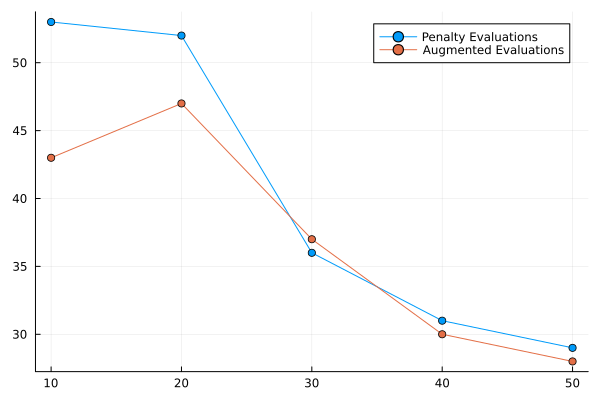

In [61]:
using Plots

# Define the number of variables (N)
N = [10, 20, 30, 40, 50]  # need to increease N

# Plot the error in the solution for both methods
plot(N, penalty_evaluations, label="Penalty Evaluations", marker=:circle)
plot!(N, augmented_evaluations, label="Augmented Evaluations", marker=:circle)


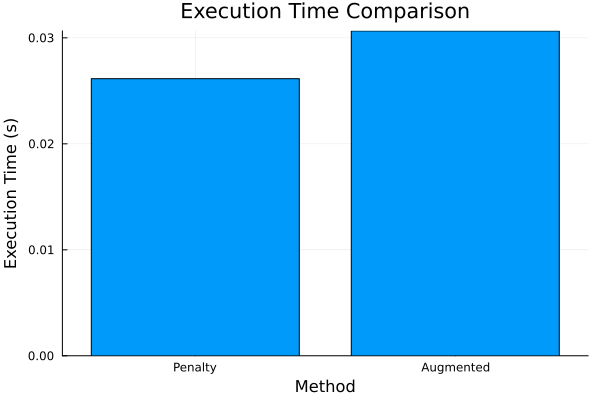

In [62]:
using Plots

# Define the methods and their corresponding execution times
methods = ["Penalty", "Augmented"]
execution_times = [penalty_times[1], augmented_times[1]]  # Accessing time when i = 1

# Create the bar plot
bar(methods, execution_times, xlabel="Method", ylabel="Execution Time (s)", title="Execution Time Comparison", legend=false)


*What do you conclude
from this?*

From the plots above we observe that both the penalty and augmented lagrangian methods give solutions that are very close to one another for $N ≈ 28$ or greater and as $N$ increases the error in both methods reduces. 
We also see that the augmented lagrangian method is slightly faster than that of the penalty method, however this is likely closer as a result of Julia's superior computational ability, and after rerunning a few times the execution times are varying, but for the most part the augmented method is slightly quicker.

#### (D)
#### Parameter Transformation

In [63]:
function rosenbrock(X, a, b)
    Y = 0
    for i in 1:length(X)-1    # Julia uses 1-based indexing
        Y += (a * (1 - X[i])^2 + b * (X[i+1] - X[i]^2)^2)
    end
    return Y
end

function h(Z, r)
    n = length(Z) + 1
    X = zeros(n)
    exp_Z = exp.(Z)
    exp_sum = sum(exp_Z)

    for i in 1:n-1
        X[i] = sqrt(exp_Z[i] / (1 + exp_sum))  # if i <= n-1; Looks a lot like the softmax function
    end
    
    X[n] = sqrt(1 / (1 + exp_sum))  # if i=n
    
    return sqrt(r) * X
end
function h_inv(X)
    n = length(X)
    Z = zeros(n-1)
    
    for i in 1:n-1
        Z[i] = 2 * log(X[i] / X[n])
    end
    
    return Z
end

# Test the functions: input should be conserved under transformation and inversion.
r = 2
x0 = [1, 1]
x1 = h(x0, r)
println(x1)
h_inv(x1)  # Should equal x0

function rosenbrock_unconstrained(Z, a, b, r)
    X = h(Z, r)
    return rosenbrock(X, a, b)
end

# Test the function:
a = 1
b = 1
r = 2

Z0 = [0.0]
X0 = rosenbrock_unconstrained(Z0, a, b, 2)
println(X0)
println(h(Z0, r))  # At X1,X2=1 or Z=0, the rosenbrock function is minimized (assuming r=2)


# Define initial guess and parameters
a = 1
b = 1
r = 2
Z0 = [5.0]  # Initial guess

# Perform minimization
result = Optim.optimize(Z -> rosenbrock_unconstrained(Z, a, b, r), Z0, LBFGS())

# Print the result
println(result)
println("------------------------------------------")
println("When Z = $(round(result.minimizer[1], digits=7)) → X = $(h([result.minimizer[1]], r)), the Rosenbrock function takes on a minimum of $(result.minimum)")

[0.919041672887055, 0.919041672887055, 0.5574269521595877]
9.860761315262648e-32
[1.0000000000000002, 1.0000000000000002]
 * Status: success

 * Candidate solution
    Final objective value:     7.039980e-18

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.48e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.42e+05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.37e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.95e+11 ≰ 0.0e+00
    |g(x)|                 = 4.19e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    14
    ∇f(x) calls:   14

------------------------------------------
When Z = -0.0 → X = [0.9999999991609542, 1.000000000839046], the Rosenbrock function takes on a minimum of 7.039979654512774e-18


*Compare to parts (a) - (c). How do your results compare? How many function evaluations does it require? Does it require more or less time to compute? What do you take away from this?*

The reparametrisation method requires $4$ iterations to reach the optimal solution, this is far quicker (in both iterations and time to compute compared to (a)-(c)) because the paramaterisation gives a smooth, well behaved convex function which is easily minimised. We see that the results support our findings from parts (a)-(c), that the minimum is at $x_0 = [1,1]$

The time stated for the computation in (d) is 0s, this is likely due to Julia's efficiencies, however we understand this to be the quickest method of solving the optimization, because of the simple nature of minimising a convex function.

To conclude, we see that all $4$ of these optimization methods are effective in minimizing the corresponding problems, however we observe certain methods are better under different conditions. For example in the penalty method, when $P_k$ grows incredibly large, we still need to solve the problem, it converges more quickly than SQP but still has numerical instabilities.

One of the benefits of the Augmented Lagrangian method (which effectively combines the penalty and uses the Lagrangian to compute a Lagrangian multiple penalty) is we don't have to wait for $P_k$ to become very large, just until $\lambda$ has converged.

Finally, as we saw in the lecture slides convexity is always our friend. And once we know the curve is convex we understand by a Theorem that every local minimum of the convex function is a global minimum, and given the function is strictly convex, continuous and its domain is compact convex set we have a unique minimum. This avoids lots of the issues we can get with the other methods where we find a local minimum but cannot verify if it is indeed a global minimum.